<a href="https://colab.research.google.com/github/Aurelien07/Kaggle_competition/blob/main/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit  Recognizer project :

Dans ce projet notre sommaire sera quelque chose similaire à ça : 

- Visualisation des données 
- Pré-traitement des données
- Choix d'un modéle (from scratch)
  - Entrainement du modéle 
  - Evaluation du modéle
  - Prédictions sur les données de test
- Choix du modéle (Transfert Learning)
  - Entrainement du modéle
  - Evaluation du modéle
  - Prédictions sur les données de test
- Comparatif entre from Scratch et Transfert Learning
- Optimisation du modéle avec GridsearchCV
- Script de détection
- Conclusion


## Visualisation des données :

### Exploration des données :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks/digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Colab Notebooks/digit-recognizer/digit_recognizer.ipynb
/content/drive/My Drive/Colab Notebooks/digit-recognizer/test.csv
/content/drive/My Drive/Colab Notebooks/digit-recognizer/sample_submission.csv
/content/drive/My Drive/Colab Notebooks/digit-recognizer/train.csv


In [4]:
test_ds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/digit-recognizer/test.csv')
train_ds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/digit-recognizer/train.csv')

let's vizualise the dataset first :

In [5]:
display(train_ds.head())
display(train_ds.info())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


None

Now let's start with our class number to know which number we will find.

### Analyse des données :

In [6]:
num_classes = len(train_ds['label'].unique()) # Count the number of unique number normally we will have 10

In [7]:
num_classes # Confirm we have 10 classes 

10

### Graphique de visualisation des données :

Now we will have some random vizualisation of the score :

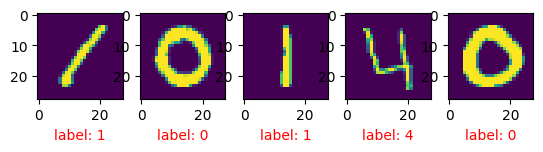

In [19]:
IMG_SIZE = (28,28,1)
# Sample digit image
sample_images = train_ds.iloc[0:5,1:].values.reshape((-1,)+IMG_SIZE) # vizualise some numbers
fig, axs = plt.subplots(1, sample_images.shape[0])
for i,img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].set_xlabel(f'label: {train_ds.iloc[i,0]}')
    axs[i].xaxis.label.set_color('red')

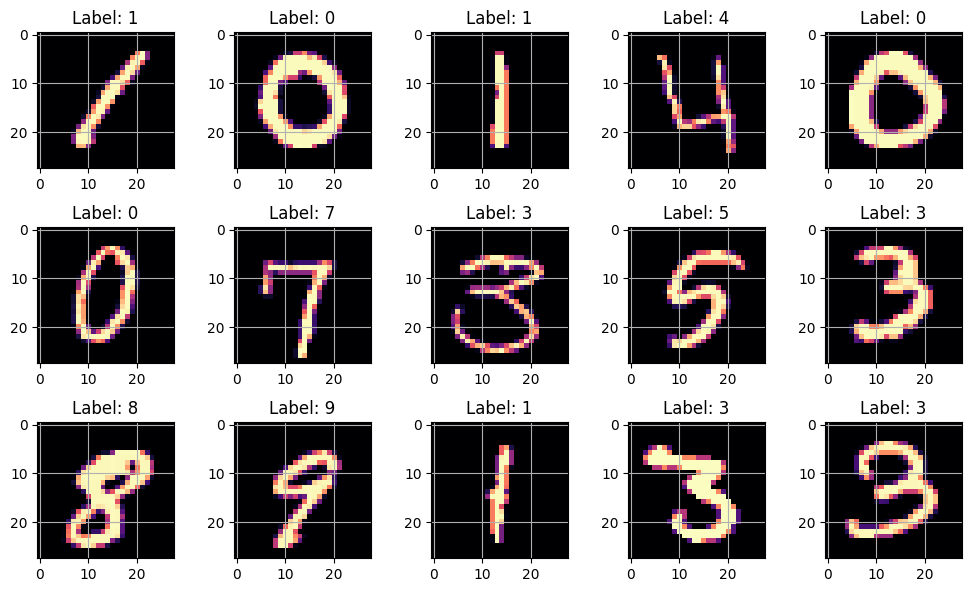

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extraire les pixels et les labels des données d'entraînement
pixels = train_ds.drop('label', axis=1).values
labels = train_ds['label'].values

# Affiche les 10 premières images avec leur titre :
fig, axes = plt.subplots(3, 5, figsize=(10, 6)) # 2 lignes avec 5 colonnes
axes = axes.flatten()


for i in range(15):
    img = pixels[i].reshape(28, 28)  # Remodeler les pixels en une image 28x28 (norme)
    axes[i].imshow(img, cmap='magma') # magma because it's a personal choice i like it !
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].grid(True) # i don't know if the grid is good or not but i like it too so..
  
plt.tight_layout()
plt.show()

## Pré-traitement des données :

__Prétraitement des données :__

- la normalisation des pixels (mettre les pixels à une échelle de 0 à 1)
- le redimensionnement des images (si entrée modéle spécifique)
- l'augmentation des données. (pour augmenter la taille du modéle et améliore la généralisation du modéle)




In [24]:
from sklearn.preprocessing import RobustScaler
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Normalisation des données :

In [28]:
# Normalisation robuste des pixels
scaler = RobustScaler()
normalized_pixels = scaler.fit_transform(pixels)

### Redimension des données : 

In [29]:
# Normalisation robuste des pixels
scaler = RobustScaler()
normalized_pixels = scaler.fit_transform(pixels)

# Redimensionnement des images
resized_images = np.array([resize(img.reshape(28, 28), (28, 28), anti_aliasing=True) for img in normalized_pixels])

# Ajouter une dimension pour les canaux de couleur (niveaux de gris)
resized_images = resized_images.reshape(resized_images.shape + (1,))

### Augmentation des données :

In [30]:
# Augmentation des données
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
datagen.fit(resized_images)  # Adapter le générateur aux données

# Générer les images augmentées
augmented_images = datagen.flow(resized_images, batch_size=1, shuffle=False)

### Visualisation du pré-traitement : 

L'augmentation des données permet de mettre de la variabilité dans les données en appliquant des transformations aléatoires aux images existantes. 

Ca améliore la capacité de généralisation du modèle en lui donnant plus de données pour l'apprentissage du modéle.

In [31]:
print("Dimensions des données originales :", resized_images.shape)
print("Dimensions des données augmentées :", augmented_images[0][0].shape)

Dimensions des données originales : (42000, 28, 28, 1)
Dimensions des données augmentées : (28, 28, 1)


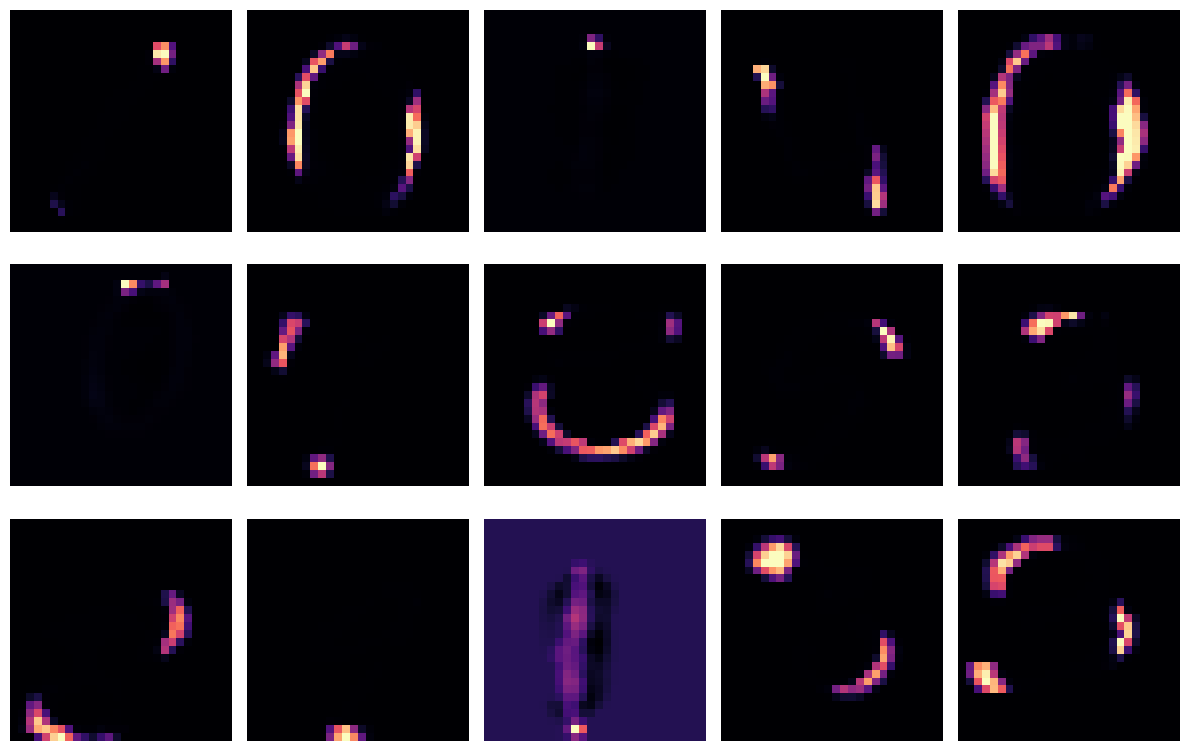

In [34]:
# Génération des images augmentées :
generated_images = datagen.flow(resized_images, batch_size=1, shuffle=False)

# Affichage des images augmentées :
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.flatten()

for i in range(15):
    img = generated_images[i][0].reshape(28, 28)  # Remodeler les pixels en une image 28x28 (norme)
    axes[i].imshow(img, cmap='magma') # choix de la couleur d'affichage (cmap)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Choix du modéle from scratch :